In [0]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# tensorflow imports
import tensorflow as tf
from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import for showing the confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2017)

In [34]:
!pip install albumentations

In [35]:
tf.__version__

'1.14.0'

In [0]:
hparams = HParams(
    n_classes=10,  # number of different classes in dataset
    learning_rate=1e-1,  # fixed learning rate
    train_batch_size=128,  # training batch size
    val_batch_size=128,  # validation batch size
    test_batch_size=256,  # testing batch size
    n_epochs=24,  # number of epochs to train
    input_name='input_1',  # name of the input tensor for first layer of Keras model
    data_dir='/tmp/cifar-data/',  # path to data directory
    checkpoint_dir='/tmp/checkpoints/'  # path to model checkpoint directory
)

In [37]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   31G  310G   9% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   40G  326G  11% /opt/bin
shm             6.0G  8.0K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [0]:
from albumentations import (
    Compose, HorizontalFlip,Cutout, Rotate, 
    ToFloat, ShiftScaleRotate,
   
)
import cv2

In [0]:
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    Cutout(num_holes=6, max_h_size=2, max_w_size=2,p=0.5),
    
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=12, border_mode=cv2.BORDER_REFLECT_101, p=0.8),     
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    
    ToFloat(max_value=255)
])

In [0]:
# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = hparams.n_classes

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def download(base_url, filename, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path)

        print(" Done!")


def maybe_download_and_extract(url=data_url, download_dir=hparams.data_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.

    If filename=="" then return the directory of the files.
    """

    return os.path.join(hparams.data_dir, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.

    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file,encoding='bytes')

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    # raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


def load_class_names():
    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.

    The data-set is split into 5 data-files which are merged here.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=np.uint8)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls


def load_validation_data():

    images, cls = _load_data(filename="test_batch")

    images = images[5000:, :, :, :]
    cls = cls[5000:]

    return images, cls

def load_testing_data():


    images, cls = _load_data(filename="test_batch")

    images = images[:5000, :, :, :]
    cls = cls[:5000]

    return images, cls

In [41]:
import matplotlib.pyplot as plt
maybe_download_and_extract()
x_val, y_val = load_validation_data()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [42]:
x_val.shape

(5000, 32, 32, 3)

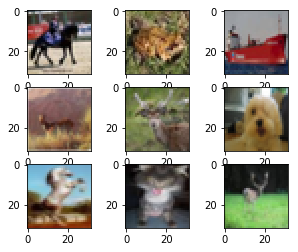

In [43]:
fig = plt.figure(figsize=(5,4))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, i * 3 + j + 1)
        ax.imshow(x_val[i * 3 + j])

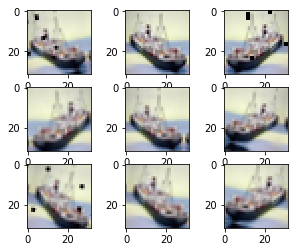

In [44]:
fig = plt.figure(figsize=(5,4))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, i * 3 + j + 1)
        ax.imshow((AUGMENTATIONS_TRAIN(image=x_val[20])["image"] * 255).astype(np.uint8))

##Sequence Class


In [0]:
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence

In [0]:
class CIFAR10Sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

In [47]:
x_val, y_val = load_validation_data()
valid_gen = CIFAR10Sequence(x_val, y_val, hparams.val_batch_size, augmentations=AUGMENTATIONS_TEST)

Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [48]:
is_generator_or_sequence(valid_gen )

True

In [49]:
valid_gen[2][0].shape

(128, 32, 32, 3)

## Network architecture

In [0]:
import tensorflow as tf
reg = tf.keras.regularizers.l1_l2(
    l1=0.0,
    l2=0.001
)

In [0]:
from tensorflow.keras import layers,models

def add_batchnorm_relu(inp):
    inp = layers.BatchNormalization()(inp)
    inp = layers.ReLU()(inp)
    return inp

class Resnet:

    def __init__(self):
        self.img_height = 32
        self.img_width = 32
        self.img_channels = 3

    def build_resnet(self):
        _input = layers.Input(shape=(self.img_height, self.img_width, self.img_channels))
        inp = self.prep(_input)

        inp = self.down_sample(inp,128)
        shortcut = inp
        inp = self.block(inp,64,128)
        inp = layers.add([shortcut,inp])

        inp = self.down_sample(inp, 256)

        inp = self.down_sample(inp, 512)
        shortcut = inp
        inp = self.block(inp,128, 512)
        inp = layers.add([shortcut, inp])

        inp = layers.GlobalMaxPooling2D()(inp)
        out = layers.Dense(10,activation='softmax',kernel_regularizer=reg)(inp)

        model = models.Model(inputs=[_input], outputs=[out])
        return model

    def prep(self,inp):
        inp = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=reg)(inp)
        inp = add_batchnorm_relu(inp)
        return inp

    def down_sample(self,inp,channel_out):
        inp = layers.Conv2D(channel_out, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=reg)(inp)
        inp = add_batchnorm_relu(inp)
        inp = layers.MaxPool2D(pool_size=(2, 2))(inp)
        return inp

    def block(self,inp,channel_in,channel_out):
        inp = layers.Conv2D(channel_in, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=reg)(inp)
        inp = add_batchnorm_relu(inp)
        inp = layers.Conv2D(channel_out, kernel_size=(3, 3), strides=(1, 1), padding='same',kernel_regularizer=reg)(inp)
        inp = add_batchnorm_relu(inp)
        return inp


In [52]:
resnet = Resnet()
model = resnet.build_resnet()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 32, 32, 64)   256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 32, 32, 64)   0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [53]:
# Download and extract CIFAR-10 data
maybe_download_and_extract()

# training data
x_train, y_train = load_training_data()
train_gen = CIFAR10Sequence(x_train, y_train, hparams.train_batch_size, augmentations=AUGMENTATIONS_TRAIN)

# Validation data
x_val, y_val = load_validation_data()
valid_gen = CIFAR10Sequence(x_val, y_val, hparams.val_batch_size, augmentations=AUGMENTATIONS_TEST)


Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [0]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

import keras
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
#from keras.losses import binary_crossentropy
#from keras.metrics import binary_accuracy
from tensorflow.keras import backend as K
#from keras.callbacks import *
from tensorflow.keras.callbacks import *

class SlantedCylicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum, inc_fraction):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        self.cycle_length = np.int(2*step_size)
        self.inc_fraction = inc_fraction
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
        
    def clr(self):
      
      cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
      
      if self.clr_iterations <= self.cycle_length*self.inc_fraction:
        unit_cycle = self.clr_iterations * 1 / (self.cycle_length * self.inc_fraction)
        adjusted_cycle = (unit_cycle * (self.max_lr - self.base_lr)) + self.base_lr
        return adjusted_cycle
      
      elif (self.cycle_length*self.inc_fraction < self.clr_iterations <= self.cycle_length):
        unit_cycle = (self.cycle_length - self.clr_iterations) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        adjusted_cycle = (unit_cycle * (self.max_lr - self.base_lr)) + self.base_lr
        return adjusted_cycle
        
      else:
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        adjusted_cycle = self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        return 0.4*adjusted_cycle
               
  
    
    def cm(self):
      
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
      
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_train_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
          K.set_value(self.model.optimizer.momentum, self.cm())

          
          
    def on_train_batch_end(self, batch, logs=None):
      logs = logs or {}
      
     
    def on_test_begin(self, batch, logs=None):
      logs = logs or {}
      
    def on_test_end(self, batch, logs=None):
      logs = logs or {}  
      
    def on_test_batch_begin(self, batch, logs=None):
      logs = logs or {}
      
      
    def on_test_batch_end(self, batch, logs=None):
      logs = logs or {}
      
      
    def on_epoch_begin(self, epoch, logs=None):
      print('lr =  ', K.get_value(self.model.optimizer.lr))
      
  

In [0]:

import tensorflow as tf
#something  = tf.keras.Sequential()
#from tf.keras.optimizers import SGD
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(0.0000001), metrics=['accuracy'])

In [56]:
# CLR parameter
batch_size = 128
epochs = 24
max_lr = 0.5
base_lr = 0.005 # Min_lr is 1/10 of max_lr
max_m = 0.90
base_m = 0.9*max_m  # Min momentum as 90% of max momentum

cyclical_momentum = False


iters = np.int(np.round((x_train.shape[0]/batch_size)*epochs,0))
iterations = list(range(0,iters+1))
print("iterations",iters)
up_epochs = 6
inc_fraction = up_epochs/epochs

print("Fract up is", inc_fraction)
up = np.int(np.round(up_epochs*(x_train.shape[0]/batch_size), 0))
print("Increasing for {} iterations" .format(up))
down_epochs = 11
down = np.int(np.round(down_epochs*(x_train.shape[0]/batch_size), 0))
print("Decreasing for {} iterations" .format(down))
cycle_length = up+down
print("cycle length is",cycle_length )
trail_epochs = epochs-up_epochs-down_epochs
trail_fraction = trail_epochs/epochs
print("Trail fraction is", trail_fraction)
cycles = 2.0+trail_fraction
print("Cycles are:", cycles)
trail = np.int(np.round(trail_epochs*(x_train.shape[0]/batch_size), 0))
print("Tail is {} iterations long" .format(trail))
print("Adding up, down and trail iterations, total is:", up+down+trail)


step_size = round(iters/cycles)  #len(iterations)
print(step_size)

iterations 9375
Fract up is 0.25
Increasing for 2344 iterations
Decreasing for 4297 iterations
cycle length is 6641
Trail fraction is 0.2916666666666667
Cycles are: 2.2916666666666665
Tail is 2734 iterations long
Adding up, down and trail iterations, total is: 9375
4091


In [0]:
slanted = SlantedCylicLR(base_lr=base_lr,max_lr=max_lr,step_size=step_size,base_m=base_m, max_m=max_m,cyclical_momentum=cyclical_momentum,inc_fraction=inc_fraction)
   

## CheckPoint

In [0]:
import os
# checkpoint for saving weights whenever val acc increases
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="best_model_07_August_2019.hdf5"
checkpoint_dir = os.path.dirname(filepath)
# alternatively use this line for saving only the best weights, this will keep getting overwritten during fit -- filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')



In [0]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(slanted)

In [0]:
#callbacks_list = [checkpoint, clr]
slant_callback = [slanted]

In [61]:
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    train_gen,
    epochs=hparams.n_epochs,
    validation_data=valid_gen,
    workers=2, use_multiprocessing=False,
    callbacks=slant_callback)

lr =   0.005
Epoch 1/24
391/391 [==============================] - 27s 68ms/step - loss: 4.9050 - acc: 0.2757 - val_loss: 4.3878 - val_acc: 0.2068
lr =   0.099619895
Epoch 2/24
391/391 [==============================] - 25s 64ms/step - loss: 3.8363 - acc: 0.3671 - val_loss: 4.8194 - val_acc: 0.2006
lr =   0.1942398
Epoch 3/24
391/391 [==============================] - 25s 64ms/step - loss: 2.7084 - acc: 0.4677 - val_loss: 2.1545 - val_acc: 0.5092
lr =   0.2888597
Epoch 4/24
391/391 [==============================] - 25s 63ms/step - loss: 2.0950 - acc: 0.5529 - val_loss: 2.0833 - val_acc: 0.5134
lr =   0.3834796
Epoch 5/24
391/391 [==============================] - 25s 64ms/step - loss: 1.5929 - acc: 0.6427 - val_loss: 1.9022 - val_acc: 0.5146
lr =   0.4780995
Epoch 6/24
391/391 [==============================] - 25s 64ms/step - loss: 1.3339 - acc: 0.6990 - val_loss: 1.1929 - val_acc: 0.7248
lr =   0.4757602
Epoch 7/24
391/391 [==============================] - 25s 64ms/step - loss: 1.1

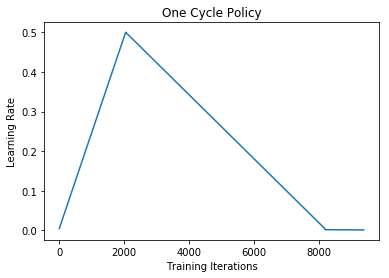

In [62]:
# Plot Learning Rate

plt.plot(slanted.history['iterations'], slanted.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

In [63]:
# Plot momentum

plt.plot(slanted.history['iterations'], slanted.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

KeyError: ignored

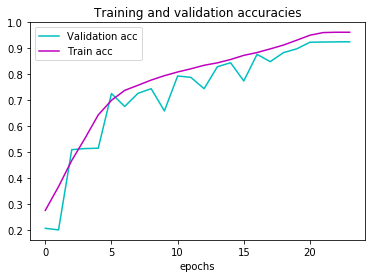

In [64]:
# Plot accuracies
val_acc = history.history['val_acc']
acc = history.history['acc']
plt.plot(range(len(val_acc)),val_acc,'c',label='Validation acc')
plt.plot(range(len(acc)),acc,'m',label='Train acc')

plt.title('Training and validation accuracies')
plt.legend()
plt.xlabel('epochs')
plt.show()